# Random SSM
This notebook trains a Random SSM on sin(x) or sin(ax+b) sequences. 
The hyperparameters are defined in the `config.yaml` file. 
- N (hidden state dimension): 64
- H (d_model in yaml, number of heads): 10

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from data import create_sin_ax_b_dataset
from model import BatchStackedModel, MultiHeadSSMLayer
import torch
from utils import cross_entropy_loss, compute_accuracy
from tqdm import tqdm

In [2]:
rng = jax.random.PRNGKey(1)

In [3]:
from omegaconf import OmegaConf

# load the configuration file
cfg = OmegaConf.load("config.yaml")

In [4]:
dataset = cfg.dataset  # str, sin_ax, sin_ax_b
layer = cfg.layer  # str, s4
seed  = cfg.seed  # int, 0
model = cfg.model  # DictConfig, {d_model: 10 (nb heads), n_layers: 4, dropout: 0.0, prenorm: true, embedding: false, layer: {N:64}}
train = cfg.train  # DictConfig, {epochs: 100, bsz: 128, lr: 0.001, lr_schedule: false, weight_decay: 0.01, checkpoint: false, suffix: null, sample: null}

In [5]:
# Set randomness...
print("[*] Setting Randomness...")
torch.random.manual_seed(seed)  # For dataloader order
key = jax.random.PRNGKey(seed)
key, rng, train_rng = jax.random.split(key, num=3) # TODO: This is bad 


[*] Setting Randomness...


In [6]:
# Check if classification dataset
# because for each dataset there are two versions, eg: mnist and mnist-classification
# TODO: in our case, sin x dataset is not a classification dataset
# classification = "classification" in dataset
classification = False
print(f'{classification=}')

create_dataset_fn = create_sin_ax_b_dataset
trainloader, testloader, n_classes, l_max, d_input, data = create_dataset_fn(n_examples=1024, bsz=train.bsz)
print(f'{n_classes=}, {l_max=}, {d_input=}')

print(f'{next(iter(trainloader))[0].shape=}')
print(f'{next(iter(testloader))[0].shape=}')

classification=False
[*] Generating sin(ax + b) Dataset...
	=>> Generating 1024 Training Examples...


100%|██████████| 1024/1024 [00:00<00:00, 5901.57it/s]


	=>> Generating 128 Test Examples...


100%|██████████| 128/128 [00:00<00:00, 8740.12it/s]


n_classes=8, l_max=16, d_input=1
next(iter(trainloader))[0].shape=torch.Size([128, 16, 1])
next(iter(testloader))[0].shape=torch.Size([128, 16, 1])


In [7]:
layer_cls = MultiHeadSSMLayer

In [8]:
model.layer.l_max = l_max # l_max comes from the dataset fn

In [9]:
# getattr returns the value of the named attribute of an object. 
# If not found, it returns the default value provided to the function.
lr_layer = getattr(layer_cls, "lr", None)  # lr_layer should be a dictionary
print(f'{lr_layer=} (if None, means that the attribute is not found)')

lr_layer=None (if None, means that the attribute is not found)


In [10]:
from functools import partial

print(f"[*] Starting `{layer}` Training on `{dataset}` =>> Initializing...")

# partial: Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguments keywords.
# a partial object is a wrapper for a callable object. The partial object can be called as though it is the wrapped callable object.
model_cls = partial(
        BatchStackedModel,
        layer_cls=layer_cls,
        d_output=n_classes,
        classification=classification,
        **model,
    )

[*] Starting `s4` Training on `sin_ax_b` =>> Initializing...


In [11]:
import optax
from flax.training import train_state


# TODO: go to create_train_state function (and skip this mapping) it's just a helper function
# As we're using Flax, we also write a utility function to return a default TrainState object.
# This function initializes model parameters, as well as our optimizer. Note that for S4 models,
# we use a custom learning rate for parameters of the S4 kernel (lr = 0.001, no weight decay).
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn
def create_train_state(
    rng,
    model_cls,
    trainloader,
    lr=1e-3,
    lr_layer=None,
    lr_schedule=False,
    weight_decay=0.0,
    total_steps=-1,
):
    print(f'[*] Creating Train State...')
    model = model_cls(training=True)
    init_rng, dropout_rng = jax.random.split(rng, num=2)
    print(f'Init')
    params = model.init(
        {"params": init_rng, "dropout": dropout_rng},
        jnp.array(next(iter(trainloader))[0].numpy()),
    )
    print(f'LRschedule')
    if lr_schedule:
        schedule_fn = lambda lr: optax.cosine_onecycle_schedule(
            peak_value=lr,
            transition_steps=total_steps,
            pct_start=0.1,
        )
    else:
        schedule_fn = lambda lr: lr
    # lr_layer is a dictionary from parameter name to LR multiplier
    if lr_layer is None:
        lr_layer = {}

    tx = optax.adamw(learning_rate=lr, weight_decay=0.01)

    # Print parameter count
    _is_complex = lambda x: x.dtype in [jnp.complex64, jnp.complex128]
    param_sizes = map_nested_fn(
        lambda k, param: param.size * (2 if _is_complex(param) else 1)
        if lr_layer.get(k, lr) > 0.0
        else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_leaves(param_sizes))}")
    print(f"[*] Total training steps: {total_steps}")

    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )


In [12]:
state = create_train_state(
    rng=rng,
    model_cls=model_cls,
    trainloader=trainloader,
    lr=train.lr,
    lr_layer=lr_layer,
    lr_schedule=train.lr_schedule,
    weight_decay=train.weight_decay,
    total_steps=len(trainloader) * train.epochs,
)

[*] Creating Train State...
Init
LRschedule
[*] Trainable Parameters: 997168
[*] Total training steps: 80


/var/folders/th/_3y3_jmx0mj98ffdxdh9fjt80000gn/T/ipykernel_38628/3608746436.py:59: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  print(f"[*] Trainable Parameters: {sum(jax.tree_leaves(param_sizes))}")


In [13]:
@partial(jax.jit, static_argnums=(4, 5))
def train_step(
    state, rng, batch_inputs, batch_labels, model, classification=False
):
    print(f'{batch_inputs.shape=}')
    print(f'{batch_labels.shape=}')
    def loss_fn(params):
        logits, mod_vars = model.apply(
            params,
            batch_inputs,
            rngs={"dropout": rng},
            mutable=["intermediates"],
        )
        loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
        acc = jnp.mean(compute_accuracy(logits, batch_labels))
        return loss, (logits, acc)

    if not classification:
        # For regression tasks, we use the input as the target
        batch_labels = batch_inputs[:, :, 0]
        print(f'{batch_labels.shape=}')

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, acc)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, acc


@partial(jax.jit, static_argnums=(3, 4))
def eval_step(batch_inputs, batch_labels, params, model, classification=False):
    print(f'{batch_inputs.shape=}')
    print(f'{batch_labels.shape=}')
    if not classification:
        batch_labels = batch_inputs[:, :, 0]
    logits = model.apply(params, batch_inputs)
    loss = jnp.mean(cross_entropy_loss(logits, batch_labels))
    acc = jnp.mean(compute_accuracy(logits, batch_labels))
    return loss, acc

In [14]:
def train_epoch(state, rng, model, trainloader, classification=False):
    # Store Metrics
    model = model(training=True)
    batch_losses, batch_accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs = jnp.array(inputs.numpy())
        labels = jnp.array(labels.numpy())  # Not the most efficient...
        rng, drop_rng = jax.random.split(rng)
        state, loss, acc = train_step(
            state,
            drop_rng,
            inputs,
            labels,
            model,
            classification=classification,
        )
        batch_losses.append(loss)
        batch_accuracies.append(acc)

    # Return average loss over batches
    return (
        state,
        jnp.mean(jnp.array(batch_losses)),
        jnp.mean(jnp.array(batch_accuracies)),
    )

In [15]:
def validate(params, model, testloader, classification=False):
    # Compute average loss & accuracy
    model = model(training=False)
    losses, accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs = jnp.array(inputs.numpy())
        labels = jnp.array(labels.numpy())  # Not the most efficient...
        loss, acc = eval_step(
            inputs, labels, params, model, classification=classification
        )
        losses.append(loss)
        accuracies.append(acc)

    return jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracies))


In [28]:
# Loop over epochs
best_loss, best_acc, best_epoch = 10000, 0, 0
print(f"Epoch | Train Loss | Train Acc | Test Loss | Test Acc")
print(f"-------------------------------------------------------")
for epoch in range(train.epochs+1000):
    state, train_loss, train_acc = train_epoch(
        state,
        train_rng,
        model_cls,
        trainloader,
        classification=classification,
    )

    test_loss, test_acc = validate(
        state.params, model_cls, testloader, classification=classification
    )
    print(f'{epoch+1:>5} | {train_loss:.5f}{"":<3} | {train_acc:.4f}{"":<3} | {test_loss:.5f}{"":<2} | {test_acc:.4f}{"":<3}')


Epoch | Train Loss | Train Acc | Test Loss | Test Acc
-------------------------------------------------------
    1 | 0.80115    | 0.6699    | 0.85988   | 0.6377   
    2 | 0.80182    | 0.6650    | 0.87755   | 0.6396   
    3 | 0.80083    | 0.6677    | 0.85692   | 0.6396   
    4 | 0.79930    | 0.6703    | 0.87522   | 0.6348   
    5 | 0.82026    | 0.6575    | 0.87911   | 0.6426   
    6 | 0.81517    | 0.6614    | 0.89764   | 0.6348   
    7 | 0.81646    | 0.6633    | 0.88847   | 0.6377   
    8 | 0.80732    | 0.6675    | 0.88609   | 0.6362   
    9 | 0.80058    | 0.6661    | 0.86066   | 0.6367   
   10 | 0.79573    | 0.6700    | 0.86717   | 0.6431   
   11 | 0.80191    | 0.6658    | 0.86171   | 0.6357   
   12 | 0.79826    | 0.6685    | 0.85563   | 0.6416   
   13 | 0.79703    | 0.6725    | 0.85356   | 0.6426   
   14 | 0.79953    | 0.6664    | 0.86483   | 0.6348   
   15 | 0.80260    | 0.6676    | 0.85632   | 0.6455   
   16 | 0.79686    | 0.6700    | 0.87332   | 0.6387   
   17 | 0.

In [21]:
inference_model = model_cls(training=False)
batch_inputs, batch_labels = next(iter(trainloader))
logits, model_variables = inference_model.apply(
    state.params,
    jnp.array(batch_inputs),
    rngs={"dropout": rng},
    mutable=["intermediates"],
)

In [73]:
logits.shape

(128, 16, 8)

In [74]:
print(f'{jnp.argmax(logits, axis=-1).shape}')

(128, 16)


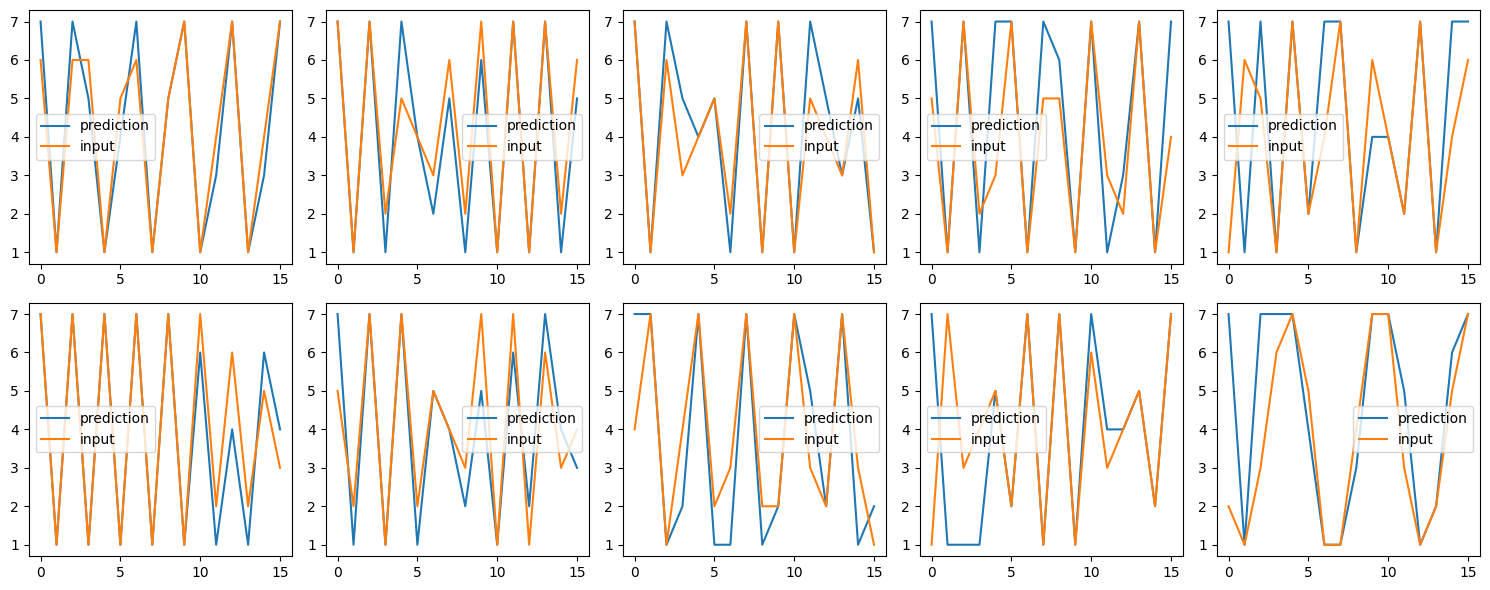

In [75]:
# plot the 10 first examples
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].plot(jnp.argmax(logits, axis=-1)[i], label='prediction')
    # plot the input
    axs[i // 5, i % 5].plot(batch_inputs[i,:,0], label='input')
    axs[i // 5, i % 5].legend()
plt.tight_layout()
plt.show()


In [27]:
# print state

In [28]:
state.params.keys()

dict_keys(['cache', 'params'])

In [29]:
state.params['params'].keys()

dict_keys(['decoder', 'encoder', 'layers_0', 'layers_1', 'layers_2', 'layers_3'])

In [30]:
next(iter(trainloader))[0].shape

torch.Size([128, 16, 1])

In [31]:
print(state.params['params']['encoder']['bias'].shape)
print(state.params['params']['encoder']['kernel'].shape)


(10,)
(1, 10)


In [32]:
print(state.params['params']['layers_0'].keys())

dict_keys(['norm', 'out', 'out2', 'seq'])


In [44]:
print(state.params['params']['layers_0']['norm'].keys())

dict_keys(['bias', 'scale'])


In [45]:
print(state.params['params']['layers_0']['norm']['bias'].shape)
print(state.params['params']['layers_0']['norm']['scale'].shape)

(10,)
(10,)


In [42]:
print(state.params['params']['layers_0']['out'].keys())
print(state.params['params']['layers_0']['out2'].keys())

dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])


In [43]:
print(state.params['params']['layers_0']['out']['bias'].shape)
print(state.params['params']['layers_0']['out']['kernel'].shape)
print(state.params['params']['layers_0']['out2']['bias'].shape)
print(state.params['params']['layers_0']['out2']['kernel'].shape)

(10,)
(10, 10)
(10,)
(10, 10)


In [33]:
print(state.params['params']['layers_0']['seq'].keys())

dict_keys(['A', 'B', 'C', 'D', 'log_step'])


In [34]:
print(state.params['params']['layers_0']['seq']['A'].shape)
print(state.params['params']['layers_0']['seq']['B'].shape)
print(state.params['params']['layers_0']['seq']['C'].shape)
print(state.params['params']['layers_0']['seq']['D'].shape)
print(state.params['params']['layers_0']['seq']['log_step'].shape)


(64, 10, 64)
(64, 10, 1)
(1, 10, 64)
(1, 10)
(1, 10)


In [34]:
print(state.params['params']['layers_0']['seq']['A'][0,0,0])
print(state.params['params']['layers_0']['seq']['A'][0,1,0])
print(state.params['params']['layers_0']['seq']['D'][0,0])
print(state.params['params']['layers_0']['seq']['D'][0,1])

0.002715726
-0.053828467
1.1623794
0.8955986


In [35]:
print(state.params['params']['decoder']['bias'].shape)
print(state.params['params']['decoder']['kernel'].shape)

(8,)
(3, 8)


In [24]:
A = 64**2
B = 64
C = 64
D = 1
H = 10 # number of heads = d_model in yaml
o = 10*10 + 10 
o2 = 10*10 + 10
norm = 10 + 10
seq_p = H*(A+B+C+D) + o + o2 + norm
n_lay = 4
enc = 10+10
dec = 10*8+10
cache_x = 128*64*10 * 4 # = batch_size * N (state dimension) * H (nb heads) * n_lay
n_p = n_lay * seq_p + enc + dec + cache_x
print(f'{n_p=} (should be 497788 -> diff {n_p-497788})')

n_p=497750 (should be 497788 -> diff -38)


In [65]:
n_examples = 1024
SEQ_LENGTH, N_CLASSES, IN_DIM = 16, 8, 1
x = np.linspace(0, 2 * np.pi, num=SEQ_LENGTH)
# jnp.digitize: Return the indices of the bins to which each value in input array belongs.
y = np.digitize(np.sin(x), np.linspace(-1, 1, num=N_CLASSES))

# Tile this `n_examples` times...
# data will be a tensor of shape (n_examples, SEQ_LENGTH, IN_DIM)
data = torch.Tensor(
    np.tile(
        np.expand_dims(np.expand_dims(y, -1), 0), reps=[n_examples, 1, 1]
    )
)
key = jax.random.PRNGKey(0)
key, rng = jax.random.split(key)
amplitudes = jax.random.uniform(rng, shape=(n_examples, 1, 1), minval=0.5, maxval=1.5)
amplitudes = np.array(amplitudes)
data = data * amplitudes


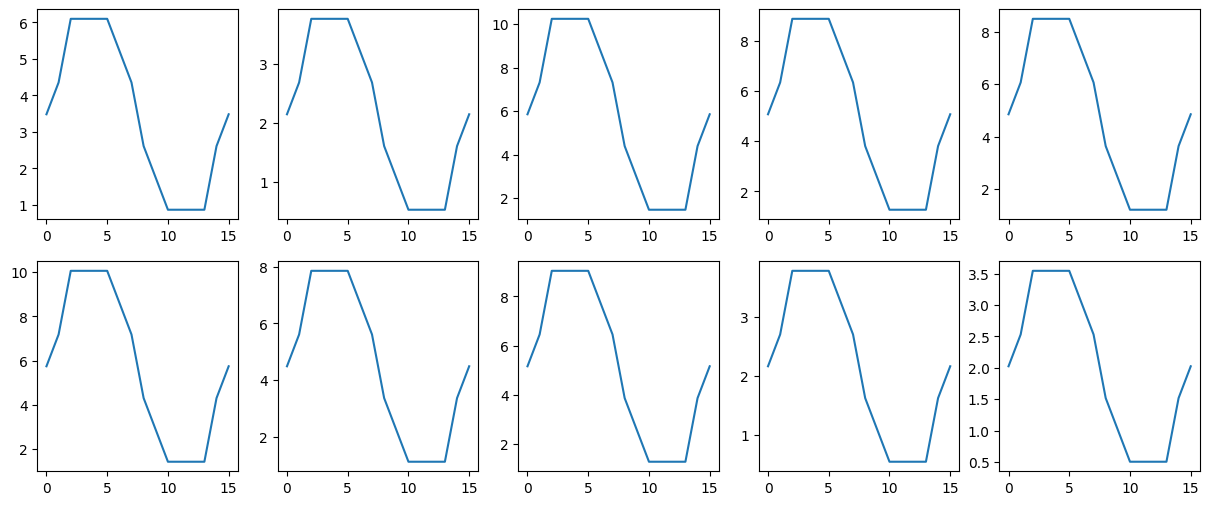

In [66]:
# plot 10 examples
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    axs[i // 5, i % 5].plot(data[i,:,0])
plt.show()


In [76]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(k_in, nested_dict):
        if k_in != None: print(f'{k_in}', end=' ')
        return {
            k: (map_fn(k, v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }
    
    return map_fn
    
a = map_nested_fn(lambda k, v: print(f'\n {k, v.shape}'))(None, state.params)

cache layers_0 seq 
 ('cache_x_k', (128, 64, 10))
layers_1 seq 
 ('cache_x_k', (128, 64, 10))
layers_2 seq 
 ('cache_x_k', (128, 64, 10))
layers_3 seq 
 ('cache_x_k', (128, 64, 10))
params decoder 
 ('bias', (8,))

 ('kernel', (10, 8))
encoder 
 ('bias', (10,))

 ('kernel', (1, 10))
layers_0 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('D', (1, 10))

 ('log_step', (1, 10))
layers_1 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('D', (1, 10))

 ('log_step', (1, 10))
layers_2 norm 
 ('bias', (10,))

 ('scale', (10,))
out 
 ('bias', (10,))

 ('kernel', (10, 10))
out2 
 ('bias', (10,))

 ('kernel', (10, 10))
seq 
 ('A', (64, 10, 64))

 ('B', (64, 10, 1))

 ('C', (1, 10, 64))

 ('

In [77]:
a

{'cache': {'layers_0': {'seq': {'cache_x_k': None}},
  'layers_1': {'seq': {'cache_x_k': None}},
  'layers_2': {'seq': {'cache_x_k': None}},
  'layers_3': {'seq': {'cache_x_k': None}}},
 'params': {'decoder': {'bias': None, 'kernel': None},
  'encoder': {'bias': None, 'kernel': None},
  'layers_0': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_1': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_2': {'norm': {'bias': None, 'scale': None},
   'out': {'bias': None, 'kernel': None},
   'out2': {'bias': None, 'kernel': None},
   'seq': {'A': None, 'B': None, 'C': None, 'D': None, 'log_step': None}},
  'layers_3': {'norm': {'bias': None, 'scale': None},
   'out': {'bias':

In [1]:
import jax 
import jax.numpy as jnp
import flax.linen as nn

In [35]:
shared_params = False
if shared_params:
    BatchDense = nn.vmap(nn.Dense, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})
else:
    BatchDense = nn.vmap(nn.Dense, in_axes=0, out_axes=0, variable_axes={'params': 0}, split_rngs={'params': True})

In [36]:
batch_size = 10
embedding_dim = 5
x = jnp.ones((batch_size, embedding_dim))
dense = BatchDense(features=3)
params = dense.init(jax.random.PRNGKey(0), x)

In [37]:
# write a function that prints recursively the keys and shapes of a nested dictionary
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(k_in, nested_dict):
        if k_in != None: print(f'{k_in}', end=' ')
        return {
            k: (map_fn(k, v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }
    
    return map_fn

map_nested_fn(lambda k, v: print(f'\n {k, v.shape}'))(None, params)

params 
 ('bias', (10, 3))

 ('kernel', (10, 5, 3))


{'params': {'bias': None, 'kernel': None}}

In [38]:
y = dense.apply(params, x)

In [39]:
y

Array([[ 1.9910165 ,  0.28383535, -1.047992  ],
       [ 1.3863918 ,  0.5475614 ,  1.2088555 ],
       [-1.3427639 , -0.58169377, -0.02100402],
       [-1.6752058 , -0.68735284, -1.4142416 ],
       [ 0.7120553 ,  0.13763508, -0.47188094],
       [ 0.59918714, -0.13747637,  0.40842372],
       [-0.18032235, -0.48730588, -1.0494046 ],
       [-0.04323477, -0.4011463 ,  0.63187987],
       [ 0.50989723,  0.20760426,  0.13128324],
       [ 0.53805596, -1.6646125 ,  1.1062521 ]], dtype=float32)

In [44]:
def step(x_k_1, u_k):
    x_k = x_k_1 + u_k
    y_k = jnp.tanh(x_k)
    return x_k, y_k
x_last, y_entire = jax.lax.scan(step, 0, jnp.ones((5,)))

In [46]:
x_last

Array(5., dtype=float32)

In [47]:
y_entire

Array([0.7615942 , 0.9640276 , 0.9950547 , 0.9993292 , 0.99990916],      dtype=float32)

In [53]:
print([float(jnp.tanh(i)) for i in range(5)])

[0.0, 0.7615941762924194, 0.9640275835990906, 0.9950547218322754, 0.9993292093276978]


In [ ]:
# q: what does u[:, jnp.newaxis] do?
# a: it adds a new axis at the end of the array

In [2]:
!pip install einops


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [19]:
import torch
from einops import repeat
import math
H=3
N=4
log_A_real = torch.log(0.5 * torch.ones(H, N))
A_imag = math.pi * repeat(torch.arange(N), 'n -> h n', h=H)


In [20]:
A_imag

tensor([[0.0000, 3.1416, 6.2832, 9.4248],
        [0.0000, 3.1416, 6.2832, 9.4248],
        [0.0000, 3.1416, 6.2832, 9.4248]])

In [21]:
log_A_real

tensor([[-0.6931, -0.6931, -0.6931, -0.6931],
        [-0.6931, -0.6931, -0.6931, -0.6931],
        [-0.6931, -0.6931, -0.6931, -0.6931]])

In [22]:
A = log_A_real + 1j * A_imag

In [23]:
A

tensor([[-0.6931+0.0000j, -0.6931+3.1416j, -0.6931+6.2832j, -0.6931+9.4248j],
        [-0.6931+0.0000j, -0.6931+3.1416j, -0.6931+6.2832j, -0.6931+9.4248j],
        [-0.6931+0.0000j, -0.6931+3.1416j, -0.6931+6.2832j, -0.6931+9.4248j]])

In [24]:
C = torch.randn(H, N // 2, dtype=torch.cfloat)
Cb = torch.view_as_real(C)
print(Cb.shape)

torch.Size([3, 4, 2])


In [25]:
Cbb = torch.view_as_complex(Cb)
print(Cbb.shape)

torch.Size([3, 4])


In [26]:
dt_min = 1e-3
dt_max = 1e-1
log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)


In [27]:
dt = torch.exp(log_dt)
dt

tensor([0.0347, 0.0453, 0.0606])

In [30]:
dt.unsqueeze(-1)

tensor([[0.0347],
        [0.0453],
        [0.0606]])

In [28]:
dtA = A * dt.unsqueeze(-1)
dtA

tensor([[-0.0241+0.0000j, -0.0241+0.1091j, -0.0241+0.2183j, -0.0241+0.3274j],
        [-0.0314+0.0000j, -0.0314+0.1424j, -0.0314+0.2848j, -0.0314+0.4272j],
        [-0.0420+0.0000j, -0.0420+0.1905j, -0.0420+0.3809j, -0.0420+0.5714j]])

In [29]:
3.1416 * 0.0347

0.10901352

In [40]:
L = 4
dtA.unsqueeze(-1) * torch.arange(L, device=A.device)

tensor([[[-0.0000+0.0000j, -0.0241+0.0000j, -0.0482+0.0000j, -0.0722+0.0000j],
         [-0.0000+0.0000j, -0.0241+0.1091j, -0.0482+0.2183j, -0.0722+0.3274j],
         [-0.0000+0.0000j, -0.0241+0.2183j, -0.0482+0.4366j, -0.0722+0.6549j],
         [-0.0000+0.0000j, -0.0241+0.3274j, -0.0482+0.6549j, -0.0722+0.9823j]],

        [[-0.0000+0.0000j, -0.0314+0.0000j, -0.0628+0.0000j, -0.0942+0.0000j],
         [-0.0000+0.0000j, -0.0314+0.1424j, -0.0628+0.2848j, -0.0942+0.4272j],
         [-0.0000+0.0000j, -0.0314+0.2848j, -0.0628+0.5696j, -0.0942+0.8543j],
         [-0.0000+0.0000j, -0.0314+0.4272j, -0.0628+0.8543j, -0.0942+1.2815j]],

        [[-0.0000+0.0000j, -0.0420+0.0000j, -0.0840+0.0000j, -0.1261+0.0000j],
         [-0.0000+0.0000j, -0.0420+0.1905j, -0.0840+0.3809j, -0.1261+0.5714j],
         [-0.0000+0.0000j, -0.0420+0.3809j, -0.0840+0.7618j, -0.1261+1.1428j],
         [-0.0000+0.0000j, -0.0420+0.5714j, -0.0840+1.1428j, -0.1261+1.7141j]]])

In [32]:
a = torch.ones(2,2)
a.unsqueeze(-1) * torch.arange(3)

tensor([[[0., 1., 2.],
         [0., 1., 2.]],

        [[0., 1., 2.],
         [0., 1., 2.]]])

In [38]:
b = torch.tensor([[1,2],[3,4]])
b.unsqueeze(-1)

tensor([[[1],
         [2]],

        [[3],
         [4]]])

In [39]:
b.unsqueeze(-1) * torch.arange(3)

tensor([[[0, 1, 2],
         [0, 2, 4]],

        [[0, 3, 6],
         [0, 4, 8]]])

In [58]:
import torch
from einops import repeat
import math
H=5
N=4
L=3
dt=0.1
log_A_real = torch.log(0.5 * torch.ones(N,))
A_imag = math.pi * torch.arange(N)
print(f'{log_A_real=}')
print(f'{A_imag=}')


log_A_real=tensor([-0.6931, -0.6931, -0.6931, -0.6931])
A_imag=tensor([0.0000, 3.1416, 6.2832, 9.4248])


In [59]:
A = -torch.exp(log_A_real) + 1j * A_imag
A

tensor([-0.5000+0.0000j, -0.5000+3.1416j, -0.5000+6.2832j, -0.5000+9.4248j])

In [60]:
dtA = A * dt
dtA

tensor([-0.0500+0.0000j, -0.0500+0.3142j, -0.0500+0.6283j, -0.0500+0.9425j])

In [61]:
dtA_unsqueeze = dtA.unsqueeze(-1)
dtA_unsqueeze

tensor([[-0.0500+0.0000j],
        [-0.0500+0.3142j],
        [-0.0500+0.6283j],
        [-0.0500+0.9425j]])

In [63]:
K = dtA_unsqueeze * torch.arange(L)
K

tensor([[-0.0000+0.0000j, -0.0500+0.0000j, -0.1000+0.0000j],
        [-0.0000+0.0000j, -0.0500+0.3142j, -0.1000+0.6283j],
        [-0.0000+0.0000j, -0.0500+0.6283j, -0.1000+1.2566j],
        [-0.0000+0.0000j, -0.0500+0.9425j, -0.1000+1.8850j]])

In [65]:
exp_K = torch.exp(K)
exp_K

tensor([[ 1.0000+0.0000j,  0.9512+0.0000j,  0.9048+0.0000j],
        [ 1.0000+0.0000j,  0.9047+0.2939j,  0.7320+0.5319j],
        [ 1.0000+0.0000j,  0.7696+0.5591j,  0.2796+0.8606j],
        [ 1.0000+0.0000j,  0.5591+0.7696j, -0.2796+0.8606j]])

In [70]:
C = torch.randn(N, dtype=torch.cfloat)
C

tensor([-0.5039+0.6777j, -1.7526-0.1343j, -0.7315+0.6349j,  1.1549-0.3224j])

In [74]:
K_end = C @ exp_K
K_end

tensor([-1.8330+0.8559j, -2.0494+0.7961j, -2.4639+0.2148j])

In [84]:
import jax
import jax.numpy as jnp
# set display to .4f in jax 
def initialization(N: int) -> torch.Tensor:
    log_A_real = torch.log(0.5 * torch.ones(N,))
    A_imag = math.pi * torch.arange(N)
    C = torch.randn(N, dtype=torch.cfloat)
    return log_A_real, A_imag, C

def init_jax(key, N: int) -> jnp.ndarray:
    log_A_real = jnp.log(0.5 * jnp.ones(N,))
    A_imag = math.pi * jnp.arange(N)
    C = jax.random.normal(key, (N,), dtype=jnp.complex64)
    return log_A_real, A_imag, C

# fix the seed
torch.manual_seed(0)
log_A_real, A_imag, C = initialization(N=4)
log_A_real, A_imag, C

(tensor([-0.6931, -0.6931, -0.6931, -0.6931]),
 tensor([0.0000, 3.1416, 6.2832, 9.4248]),
 tensor([ 1.0896-0.2075j, -1.5406+0.4019j, -0.7669-0.9890j,  0.2852+0.5926j]))

In [85]:
log_A_real_jax, A_imag_jax, C_jax = init_jax(jax.random.PRNGKey(0), N=4)
log_A_real_jax, A_imag_jax, C_jax

(Array([-0.6931472, -0.6931472, -0.6931472, -0.6931472], dtype=float32),
 Array([0.       , 3.1415927, 6.2831855, 9.424778 ],      dtype=float32, weak_type=True),
 Array([ 0.09823954+0.8046016j ,  0.9692087 -0.10133854j,
        -0.3755876 -0.41827938j,  0.01438101+0.5619111j ], dtype=complex64))

In [86]:
def kernel(log_A_real, A_imag, C, dt, L):
    A = -torch.exp(log_A_real) + 1j * A_imag
    dtA = A * dt
    K = dtA.unsqueeze(-1) * torch.arange(L)
    exp_K = torch.exp(K)
    K_end = C @ exp_K
    return K_end

def kernel_jax(log_A_real, A_imag, C, dt, L):
    A = -jnp.exp(log_A_real) + 1j * A_imag
    dtA = A * dt
    K = dtA[:, jnp.newaxis] * jnp.arange(L)
    exp_K = jnp.exp(K)
    K_end = C @ exp_K
    return K_end

In [87]:
import time

In [95]:
%timeit kernel(log_A_real, A_imag, C, 0.1, L=3)

18.9 µs ± 144 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [89]:
%timeit kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, 3)

160 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [92]:
jit_kernel_jax = jax.jit(kernel_jax, static_argnums=(3, 4))
# warmup 
jit_kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, 3)

Array([0.70624167+0.84689474j, 0.5204996 +0.75193024j,
       0.6196348 +0.5844165j ], dtype=complex64)

In [94]:
%timeit jit_kernel_jax(log_A_real_jax, A_imag_jax, C_jax, 0.1, L=3)

4.11 µs ± 935 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [132]:
log_A_real_list = []
A_imag_list = []
C_list = []
H = 10
N = 64
key = jax.random.PRNGKey(0)
for i in range(H):
    key, subkey = jax.random.split(key)
    log_A_real, A_imag, C = init_jax(subkey, N=N)
    log_A_real_list.append(log_A_real)
    A_imag_list.append(A_imag)
    C_list.append(C)
log_A_real_batch = jnp.stack(log_A_real_list)
A_imag_batch = jnp.stack(A_imag_list)
C_batch = jnp.stack(C_list)
print(f'{log_A_real_batch.shape=}')
print(f'{A_imag_batch.shape=}')
print(f'{C_batch.shape=}')
print(log_A_real_batch + 1j * A_imag_batch)

log_A_real_batch.shape=(10, 64)
A_imag_batch.shape=(10, 64)
C_batch.shape=(10, 64)
[[-0.6931472  +0.j        -0.6931472  +3.1415927j -0.6931472  +6.2831855j
  -0.6931472  +9.424778j  -0.6931472 +12.566371j  -0.6931472 +15.707964j
  -0.6931472 +18.849556j  -0.6931472 +21.99115j   -0.6931472 +25.132742j
  -0.6931472 +28.274334j  -0.6931472 +31.415928j  -0.6931472 +34.55752j
  -0.6931472 +37.699112j  -0.6931472 +40.840706j  -0.6931472 +43.9823j
  -0.6931472 +47.12389j   -0.6931472 +50.265484j  -0.6931472 +53.407078j
  -0.6931472 +56.548668j  -0.6931472 +59.69026j   -0.6931472 +62.831856j
  -0.6931472 +65.97345j   -0.6931472 +69.11504j   -0.6931472 +72.25663j
  -0.6931472 +75.398224j  -0.6931472 +78.53982j   -0.6931472 +81.68141j
  -0.6931472 +84.823006j  -0.6931472 +87.9646j    -0.6931472 +91.106186j
  -0.6931472 +94.24778j   -0.6931472 +97.38937j   -0.6931472+100.53097j
  -0.6931472+103.67256j   -0.6931472+106.814156j  -0.6931472+109.95575j
  -0.6931472+113.097336j  -0.6931472+116.23893j

In [136]:
vmap_kernel_jax = jax.vmap(jit_kernel_jax, in_axes=(0, 0, 0, None, None))
# warmup
vmap_kernel_jax(log_A_real_batch, A_imag_batch, C_batch, 0.1, 128)

Array([[ 4.93954849e+00-7.8557873e-01j,  1.10475659e+00-1.1616502e+01j,
        -1.03798866e-01+4.1941798e-01j, ...,
        -7.51979509e-03-1.0882646e-02j,  6.20917045e-03-1.8583246e-02j,
         1.21726161e-02-1.3888414e-02j],
       [-4.04846907e-01+8.7479954e+00j,  5.16121721e+00-2.3994251e-01j,
        -2.49888492e+00-2.6765285e+00j, ...,
         1.91112496e-02-1.3435737e-03j,  1.23324292e-03+3.1608322e-03j,
         4.53132531e-03-9.6221790e-03j],
       [-6.86919308e+00+1.1445875e+01j, -3.01707697e+00-1.9842070e+01j,
         3.69161034e+00+4.1499758e+00j, ...,
         9.38161649e-03-8.1465840e-03j, -1.20261209e-02+9.6609816e-03j,
        -1.32796876e-02-4.7527147e-03j],
       ...,
       [-2.59423447e+00+6.4350688e-01j, -2.92640305e+00-9.5094881e+00j,
        -4.76090574e+00-1.9538455e+00j, ...,
         1.01800896e-02-1.5535339e-02j, -2.54037790e-04-2.9856451e-03j,
        -1.15122208e-02-4.4159214e-03j],
       [-4.17223358e+00-4.4832230e-01j, -7.96455956e+00+7.3788130e-0

In [137]:
%timeit vmap_kernel_jax(log_A_real_batch, A_imag_batch, C_batch, 0.1, 3)

443 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [138]:
def batch_init_torch(H, N):
    log_A_real = torch.log(0.5 * torch.ones(H, N))
    A_imag = math.pi * repeat(torch.arange(N), 'n -> h n', h=H)
    C = torch.randn(H, N, dtype=torch.cfloat)
    return log_A_real, A_imag, C

batch_log_A_real_torch, batch_A_imag_torch, batch_C_torch = batch_init_torch(H=10, N=4)
print(f'{batch_log_A_real_torch.shape=}')
print(f'{batch_A_imag_torch.shape=}')
print(f'{batch_C_torch.shape=}')
print(log_A_real_batch + 1j * A_imag_batch)

batch_log_A_real_torch.shape=torch.Size([10, 4])
batch_A_imag_torch.shape=torch.Size([10, 4])
batch_C_torch.shape=torch.Size([10, 4])
[[-0.6931472  +0.j        -0.6931472  +3.1415927j -0.6931472  +6.2831855j
  -0.6931472  +9.424778j  -0.6931472 +12.566371j  -0.6931472 +15.707964j
  -0.6931472 +18.849556j  -0.6931472 +21.99115j   -0.6931472 +25.132742j
  -0.6931472 +28.274334j  -0.6931472 +31.415928j  -0.6931472 +34.55752j
  -0.6931472 +37.699112j  -0.6931472 +40.840706j  -0.6931472 +43.9823j
  -0.6931472 +47.12389j   -0.6931472 +50.265484j  -0.6931472 +53.407078j
  -0.6931472 +56.548668j  -0.6931472 +59.69026j   -0.6931472 +62.831856j
  -0.6931472 +65.97345j   -0.6931472 +69.11504j   -0.6931472 +72.25663j
  -0.6931472 +75.398224j  -0.6931472 +78.53982j   -0.6931472 +81.68141j
  -0.6931472 +84.823006j  -0.6931472 +87.9646j    -0.6931472 +91.106186j
  -0.6931472 +94.24778j   -0.6931472 +97.38937j   -0.6931472+100.53097j
  -0.6931472+103.67256j   -0.6931472+106.814156j  -0.6931472+109.955

In [139]:
def batch_kernel(log_A_real, A_imag, C, dt, L):
    A = -torch.exp(log_A_real) + 1j * A_imag
    dtA = A * dt
    K = dtA.unsqueeze(-1) * torch.arange(L)
    #print(f'{K.shape=}')
    exp_K = torch.exp(K)
    K_end = torch.einsum('hn, hnl -> hl', C, exp_K)
    return K_end

In [144]:
%timeit batch_kernel(batch_log_A_real_torch, batch_A_imag_torch, batch_C_torch, 0.1, 128)

115 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [145]:
batch_kernel(batch_log_A_real_torch, batch_A_imag_torch, batch_C_torch, 0.1, 128)

tensor([[-4.3008e-01+1.2949e+00j, -4.5447e-01+1.4629e+00j,
         -8.6903e-01+1.5014e+00j,  ...,
         -2.9321e-03-7.6225e-04j, -1.3982e-03-1.4989e-03j,
         -1.0464e-04-1.1779e-03j],
        [ 1.3262e+00+1.5765e-02j,  1.4889e+00+1.5837e+00j,
          3.6505e-01+2.8774e+00j,  ...,
         -7.5105e-03+7.7568e-04j, -5.6297e-03-2.1715e-03j,
         -2.9498e-03-2.9153e-03j],
        [ 1.8445e+00+1.3649e+00j,  1.5746e+00+1.4333e+00j,
          1.2392e+00+1.4710e+00j,  ...,
          3.6131e-04+1.1230e-03j,  7.9403e-04-4.7692e-04j,
          2.1474e-03-1.4642e-03j],
        ...,
        [-5.7233e-01-2.4335e+00j,  1.1044e+00-6.3042e-01j,
          6.8477e-01+1.4851e+00j,  ...,
         -6.5966e-03-1.6509e-03j, -3.1269e-03-4.3812e-03j,
          9.2000e-04-3.4647e-03j],
        [ 4.8408e-01-1.6851e+00j,  7.5634e-01-4.6490e-01j,
         -2.0635e-02+3.2449e-01j,  ...,
         -8.6199e-04-4.8899e-03j,  2.6942e-03-4.5556e-03j,
          5.0336e-03-1.5003e-03j],
        [-1.2433e+00+1

In [146]:
def batch_kernel_jax(log_A_real, A_imag, C, dt, L):
    A = -jnp.exp(log_A_real) + 1j * A_imag
    dtA = A * dt
    K = dtA[..., jnp.newaxis] * jnp.arange(L)
    exp_K = jnp.exp(K)
    K_end = jnp.einsum('hn, hnl -> hl', C, exp_K)
    return K_end

In [150]:
jit_batch_kernel_jax = jax.jit(batch_kernel_jax, static_argnums=(3, 4))
# warmup
jit_batch_kernel_jax(log_A_real_batch, A_imag_batch, C_batch, 0.1, 128)

Array([[ 4.93954849e+00-7.8557873e-01j,  1.10475659e+00-1.1616502e+01j,
        -1.03798866e-01+4.1941798e-01j, ...,
        -7.51979509e-03-1.0882646e-02j,  6.20917045e-03-1.8583246e-02j,
         1.21726161e-02-1.3888414e-02j],
       [-4.04846907e-01+8.7479954e+00j,  5.16121721e+00-2.3994251e-01j,
        -2.49888492e+00-2.6765285e+00j, ...,
         1.91112496e-02-1.3435737e-03j,  1.23324292e-03+3.1608322e-03j,
         4.53132531e-03-9.6221790e-03j],
       [-6.86919308e+00+1.1445875e+01j, -3.01707697e+00-1.9842070e+01j,
         3.69161034e+00+4.1499758e+00j, ...,
         9.38161649e-03-8.1465840e-03j, -1.20261209e-02+9.6609816e-03j,
        -1.32796876e-02-4.7527147e-03j],
       ...,
       [-2.59423447e+00+6.4350688e-01j, -2.92640305e+00-9.5094881e+00j,
        -4.76090574e+00-1.9538455e+00j, ...,
         1.01800896e-02-1.5535339e-02j, -2.54037790e-04-2.9856451e-03j,
        -1.15122208e-02-4.4159214e-03j],
       [-4.17223358e+00-4.4832230e-01j, -7.96455956e+00+7.3788130e-0

In [151]:
%timeit jit_batch_kernel_jax(log_A_real_batch, A_imag_batch, C_batch, 0.1, 128)

425 µs ± 211 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [152]:
!pip freeze | grep torch

torch==2.1.2


In [156]:
torch.mps.

TypeError: 'module' object is not iterable

In [158]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("GOOD NEWS! MPS is available on this machine.")
    mps_device = torch.device("mps")

    # Create a Tensor directly on the mps device
    x = torch.ones(5, device=mps_device)
    # Or
    x = torch.ones(5, device="mps")

    # Any operation happens on the GPU
    y = x * 2
    print(y.device)

GOOD NEWS! MPS is available on this machine.
mps:0
